<a href="https://colab.research.google.com/github/Epalaciol/VisionArtificial_2021_Retinas/blob/master/TrabajoRetinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Vision Artificial Retinas

##Integrantes: 
- Alejandra Betancur Palacio
- Juan Camilo  Molina Roncancio
- Esteban Palacio Londoño
- Valentina Tamayo Guarin 
- Mateo Valencia Diaz
- Angie Tatiana Solano Rodriguez


## Introducción

[Inserte aqui la intro]


## Preprocesamiento de imagenes

In [108]:
!pip install opencv-contrib-python


In [109]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import io, color

In [52]:
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None
    

In [ ]:
Luego de analizar los respectivos canales para el preprocesamiento, se consideró como más apto el canal verde (G), 
perteneciente al modelo de color RGB. Este canal resultó ser más favorable puesto que hay mayor contraste 
en las partes de interés,lo cual nos permite observar diferencia significativa de los vasos sanguíneos de la retina del ojo. 

Evidenciamos la necesidad de realizar un pre procesamiento para mejorar la detección de los mismos, ya que las
imágenes tienen una iluminación no uniforme, poco contraste y ruido. Con la finalidad de contra restar las condiciones,
para así mejorar la imagen.

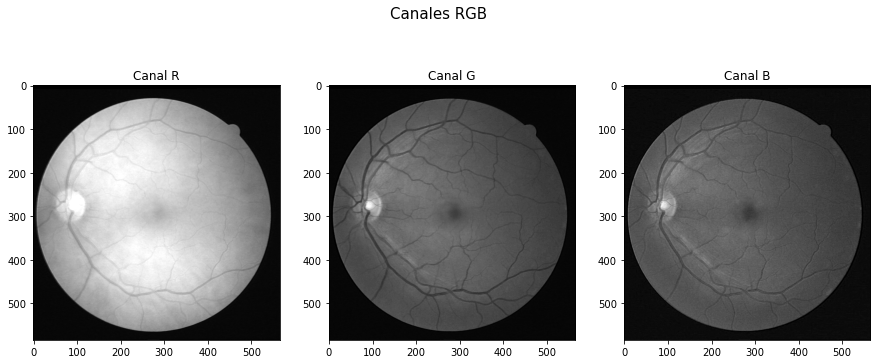

In [206]:
img_rgb = img_read('images/training/images/35_training.tif')
#Modelo RGB
img_R = img_rgb[:,:,0]
img_G = img_rgb[:,:,1]
img_B = img_rgb[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales RGB', fontsize=15)
ax1.set_title('Canal R')
ax1.imshow(img_R, cmap='gray')
ax2.set_title('Canal G')
ax2.imshow(img_G, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')


Se implemento la corrección o transformación Gamma, la cual se usa para manipular el contraste y realzar la imagen. Para este caso con el fin de aumentar el brillo, lo cual nos permitió resaltar la visualización de los vasos.

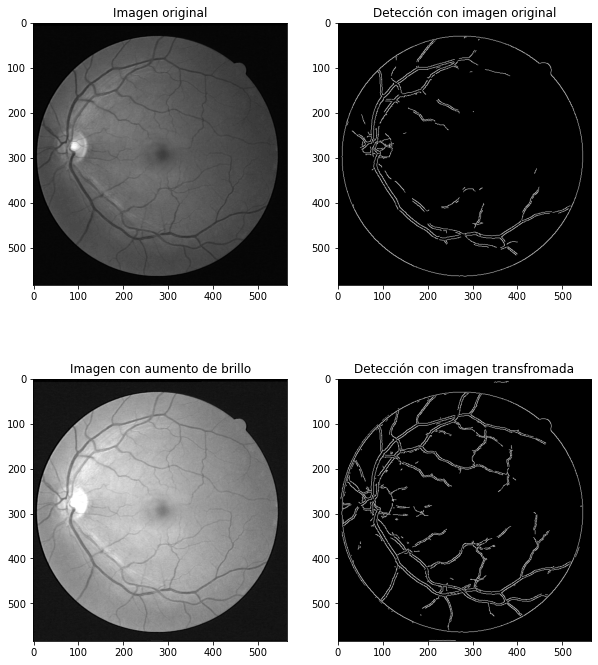

In [203]:
#Definir la función de transformación de la imagen (corrección gamma)
def gamma_correction(img, a, gamma):
        
    #Crear copia de la imagen tipo flotante dada la normalización
    img_copy = img.copy().astype(np.float32)/255.0
    #La función corrección gamma es de la forma ax^gamma donde x es la imagen de entrada
    res_gamma = cv2.pow(img_copy, gamma)
    res = cv2.multiply(res_gamma, a)
    
    #Asegurar que la los datos queden entre 0 y 255 y sean uint8
    res[res<0] = 0
    res = res*255.0
    res[res>255] = 255
    
    res = res.astype(np.uint8)
    
    return res

#Leer la imagen de entrada


#Variar los parámetros a y gamma y volver a aplicar la corrección
a = 1.5
gamma = 0.8

res_oscuro = gamma_correction(img_G, a, gamma)

#Generar un subplot 2x2 para contrastar imágen original con transformada y sus histogramas
fig, arreglo_plots = plt.subplots(2,2, figsize=(10, 12))
colors = ('r','g','b')

edges_gamma = cv2.Canny(res_oscuro,80,140)
edges_G=cv2.Canny(img_G,80,140)

arreglo_plots[0,0].set_title('Imagen original')
arreglo_plots[0,0].imshow(img_G, cmap='gray')
arreglo_plots[0,1].set_title('Detección con imagen original')
arreglo_plots[0,1].imshow(edges_G, cmap='gray')

    
arreglo_plots[1,0].set_title('Imagen con aumento de brillo')
arreglo_plots[1,0].imshow(res_oscuro, cmap= 'gray')
arreglo_plots[1,1].set_title("Detección con imagen transfromada")
arreglo_plots[1,1].imshow(edges_gamma, cmap= 'gray')

Usamos ecualización, que es una de las técnicas más utilizadas para la mejora del contraste de la imagen.Para nuestro caso las imágenes presentan desigualdad de iluminación, lo que lleva a que los vasos sanguineos no se segmenten de manera adecuada. Para mitigar este problema se propone una ecualización del histograma, que nos permite observar un realce de los mismos.


<Figure size 432x288 with 0 Axes>

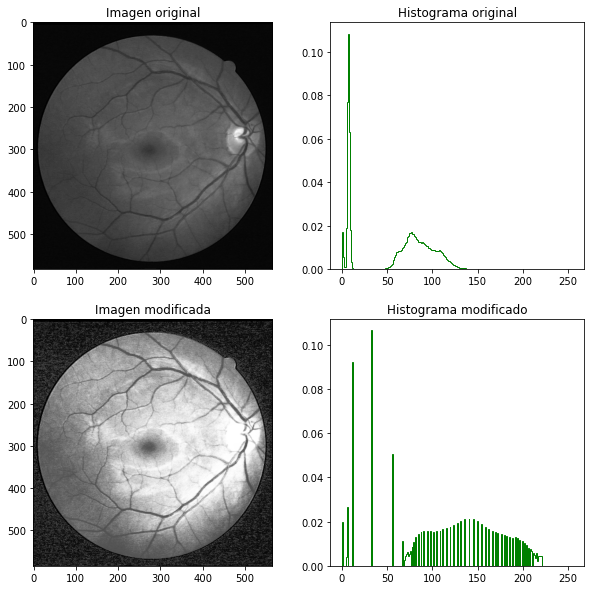

In [209]:
#Definir la función ecualización del histograma cuyo parámetro es una imagen
img_rgb1 = img_read('images/training/images/29_training.tif')
#Modelo RGB
img_G2 = img_rgb1[:,:,1]



def histogram_equalization(img):
         
    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros(img.shape, np.float32)
    #Crear un vector 1-D de la matriz de la imagen es decir \aplanarla\
    img_raveled = img.ravel()
    #Generar el histograma normalizado de la imagen 
    hist_norm = plt.hist(img_raveled, bins=255, range=(0.0, 255.0), density=True)
    #Limpiar la figura actual
    plt.clf()
    #hist_norm[0] es un vector de probabilidades. Añadir al vector el valor [1 - sumatoria de sus datos]
    pdf = hist_norm[0]
    np.append(pdf, 1.0 - np.sum(pdf))
    #Dado que se añade un dato se realiza la sumatoria de valores sobre todo el vector
    cdf = [np.sum(pdf[0:x]) for x in range(0,256)]
    #Hallar el valor mínimo y máximo de la imagen
    gmin = np.min(img)
    gmax = np.max(img)
    
    #Generar F(g) - Función de ecualización
    for g in range(0,256):
        res[img == g] = (gmax - gmin)*cdf[g] + gmin
    #Asegurar que los datos sean uint8 y esten en el rango correspondiente
    res[res<0] = 0
    res[res>255] = 255
    res = res.astype(np.uint8)
    return res

#Leer la imagen y aplicar la transformación ecualización del histograma sobre ésta



res_ecua= histogram_equalization(img_G2)

#Generar subplot 2x3 para mostrar imagen histograma y función de densidad acumulada
fig, arreglo_plots = plt.subplots(2,2 ,figsize=(10 ,10))
colors = ('r','g','b')

arreglo_plots[0,0].set_title('Imagen original')
arreglo_plots[0,0].imshow(img_G2, cmap='gray')
arreglo_plots[0,1].set_title('Histograma original')
img_array_i = img_G.ravel()
_=arreglo_plots[0,1].hist(img_array_i,histtype='step', bins=255 ,
                            range=(0.0, 255.0),density=True ,color=colors[1])

arreglo_plots[1,0].set_title('Imagen modificada')
arreglo_plots[1,0].imshow(res_ecua, cmap="gray")
arreglo_plots[1,1].set_title('Histograma modificado')
img_array_i = res_ecua.ravel()
_=arreglo_plots[1,1].hist(img_array_i,histtype='step', bins=255,
                          range=(0.0, 255.0),density=True, color=colors[1])


Con la ecualización obtenemos un buen resultado, pero genera mucho ruido al aplicar el Filtro gaussiano, se observa la mejora que obtenemos en la detección bordes.

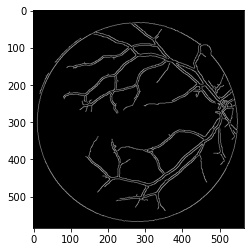

In [210]:
res_gauss= cv2.GaussianBlur(res_ecua,(5, 5),2)
edges = cv2.Canny(res_gauss,50,140)
plt.imshow(edges, cmap = 'gray')
#edges1 = cv2.Canny(res_ecua,100,160)
#plt.imshow(edges1, cmap = 'gray')
